<a href="https://www.kaggle.com/code/kursatdinc/store-item-demand-forecasting-time-series-with-ml?scriptVersionId=193930530" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Store Item Demand Forecasting

# Variables

* **Date**
* **Store**
* **Item**
* **Sales**

# Importings

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns


from lightgbm import LGBMRegressor
from lightgbm import early_stopping, log_evaluation

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)

# Load Dataset

In [3]:
def load():
    train = pd.read_csv("/kaggle/input/demand-forecasting-kernels-only/train.csv", parse_dates=["date"])
    test = pd.read_csv("/kaggle/input/demand-forecasting-kernels-only/test.csv", parse_dates=["date"])

    sample_sub = pd.read_csv("/kaggle/input/demand-forecasting-kernels-only/sample_submission.csv")

    df = pd.concat([train, test], sort=False)

    return df, train, test, sample_sub

df, train, test, sample_sub = load()

In [4]:
df.head(10)

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN
5,2013-01-06,1,1,12.0,NaN
6,2013-01-07,1,1,10.0,NaN
7,2013-01-08,1,1,9.0,NaN
8,2013-01-09,1,1,12.0,NaN
9,2013-01-10,1,1,9.0,NaN


In [5]:
df.tail(10)

,date,store,item,sales,id
44990,2018-03-22,10,50,NaN,44990.0
44991,2018-03-23,10,50,NaN,44991.0
44992,2018-03-24,10,50,NaN,44992.0
44993,2018-03-25,10,50,NaN,44993.0
44994,2018-03-26,10,50,NaN,44994.0
44995,2018-03-27,10,50,NaN,44995.0
44996,2018-03-28,10,50,NaN,44996.0
44997,2018-03-29,10,50,NaN,44997.0
44998,2018-03-30,10,50,NaN,44998.0
44999,2018-03-31,10,50,NaN,44999.0


# Overview & Preprocessing

In [6]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Unique #####################")
    print(dataframe.nunique())
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())

In [7]:
check_df(df)

##################### Shape #####################
(958000, 5)
##################### Types #####################
date     datetime64[ns]
store             int64
item              int64
sales           float64
id              float64
dtype: object
##################### Unique #####################
date      1916
store       10
item        50
sales      213
id       45000
dtype: int64
##################### Head #####################
        date  store  item  sales  id
0 2013-01-01      1     1   13.0 NaN
1 2013-01-02      1     1   11.0 NaN
2 2013-01-03      1     1   14.0 NaN
3 2013-01-04      1     1   13.0 NaN
4 2013-01-05      1     1   10.0 NaN
##################### Tail #####################
            date  store  item  sales       id
44995 2018-03-27     10    50    NaN  44995.0
44996 2018-03-28     10    50    NaN  44996.0
44997 2018-03-29     10    50    NaN  44997.0
44998 2018-03-30     10    50    NaN  44998.0
44999 2018-03-31     10    50    NaN  44999.0
###################

In [8]:
df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [9]:
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

In [10]:
df.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T

,count,mean,min,0%,5%,50%,95%,99%,100%,max,std
date,958000,2015-08-16 11:59:59.999999744,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-04-06 00:00:00,2015-08-16 12:00:00,2017-12-26 00:00:00,2018-03-12 00:00:00,2018-03-31 00:00:00,2018-03-31 00:00:00,NaN
store,958000.0,5.5,1.0,1.0,1.0,5.5,10.0,10.0,10.0,10.0,2.872283
item,958000.0,25.5,1.0,1.0,3.0,25.5,48.0,50.0,50.0,50.0,14.430877
sales,913000.0,52.250287,0.0,0.0,16.0,47.0,107.0,135.0,231.0,231.0,28.801144
id,45000.0,22499.5,0.0,0.0,2249.95,22499.5,42749.05,44549.01,44999.0,44999.0,12990.525394


# Feature Engineering

## Create Date Features

In [11]:
def create_date_features(df):
    df["month"] = df.date.dt.month
    df["day_of_month"] = df.date.dt.day
    df["day_of_year"] = df.date.dt.dayofyear
    df["week_of_year"] = df.date.dt.isocalendar().week
    df["day_of_week"] = df.date.dt.dayofweek
    df["year"] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df["is_month_start"] = df.date.dt.is_month_start.astype(int)
    df["is_month_end"] = df.date.dt.is_month_end.astype(int)
    return df

In [12]:
df = create_date_features(df)
df

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0


In [13]:
print("##################### Shape #####################")
print(df.shape)
print("##################### Types #####################")
print(df.dtypes)

##################### Shape #####################
(958000, 14)
##################### Types #####################
date              datetime64[ns]
store                      int64
item                       int64
sales                    float64
id                       float64
month                      int32
day_of_month               int32
day_of_year                int32
week_of_year              UInt32
day_of_week                int32
year                       int32
is_wknd                    int32
is_month_start             int64
is_month_end               int64
dtype: object


## Define Random Noise to Prevent Overfitting

In [14]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe)))

## Lag/Shifted Features

In [15]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe["sales_lag_" + str(lag)] = dataframe.groupby(["store", "item"])["sales"].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [16]:
df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])
df

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,38.634507,56.221351,65.972672,68.712864,67.372535,81.084920,79.443458,56.682756,98.434797,73.460666
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,62.044031,49.597717,66.043588,58.742290,75.316574,80.914631,78.913127,71.893565,79.609343,68.047587
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0,57.888518,60.904827,71.132110,65.748895,76.842541,84.958524,79.617161,66.392999,100.250830,75.907246
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0,75.331145,71.703643,72.217690,65.558331,66.313942,79.031104,91.232456,66.982095,79.600458,83.845670


In [17]:
print("##################### Shape #####################")
print(df.shape)
print("##################### Types #####################")
print(df.dtypes)

##################### Shape #####################
(958000, 24)
##################### Types #####################
date              datetime64[ns]
store                      int64
item                       int64
sales                    float64
id                       float64
month                      int32
day_of_month               int32
day_of_year                int32
week_of_year              UInt32
day_of_week                int32
year                       int32
is_wknd                    int32
is_month_start             int64
is_month_end               int64
sales_lag_91             float64
sales_lag_98             float64
sales_lag_105            float64
sales_lag_112            float64
sales_lag_119            float64
sales_lag_126            float64
sales_lag_182            float64
sales_lag_364            float64
sales_lag_546            float64
sales_lag_728            float64
dtype: object


## Rolling Mean Features

In [18]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe["sales_roll_mean_" + str(window)] = dataframe.groupby(["store", "item"])["sales"]. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

In [19]:
df = roll_mean_features(df, [365, 546])
df

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,38.634507,56.221351,65.972672,68.712864,67.372535,81.084920,79.443458,56.682756,98.434797,73.460666,89.189159,87.298859
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,62.044031,49.597717,66.043588,58.742290,75.316574,80.914631,78.913127,71.893565,79.609343,68.047587,87.660164,86.759577
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,3,2018,0,0,0,57.888518,60.904827,71.132110,65.748895,76.842541,84.958524,79.617161,66.392999,100.250830,75.907246,88.937687,85.771649
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,4,2018,1,0,0,75.331145,71.703643,72.217690,65.558331,66.313942,79.031104,91.232456,66.982095,79.600458,83.845670,89.267524,88.085056


In [20]:
print("##################### Shape #####################")
print(df.shape)
print("##################### Types #####################")
print(df.dtypes)

##################### Shape #####################
(958000, 26)
##################### Types #####################
date                   datetime64[ns]
store                           int64
item                            int64
sales                         float64
id                            float64
month                           int32
day_of_month                    int32
day_of_year                     int32
week_of_year                   UInt32
day_of_week                     int32
year                            int32
is_wknd                         int32
is_month_start                  int64
is_month_end                    int64
sales_lag_91                  float64
sales_lag_98                  float64
sales_lag_105                 float64
sales_lag_112                 float64
sales_lag_119                 float64
sales_lag_126                 float64
sales_lag_182                 float64
sales_lag_364                 float64
sales_lag_546                 float64
sales_lag_728

## Exponentially Weighted Mean Features

In [21]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe["sales_ewm_alpha_" + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])["sales"].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [22]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)
df

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,2,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,3,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,4,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,5,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,1,2018,0,0,0,38.634507,56.221351,65.972672,68.712864,67.372535,81.084920,79.443458,56.682756,98.434797,73.460666,89.189159,87.298859,41.561777,54.028375,66.387487,67.349358,81.895724,112.421502,66.744209,94.617783,71.979468,42.244368,54.197995,65.849785,66.785772,81.777579,112.682169,67.473304,92.561560,71.115472,43.955442,54.879654,64.996171,65.861563,81.488819,112.703381,68.859556,89.361543,69.838571,46.091666,55.909793,64.428121,65.144155,81.162051,112.055216,70.090358,87.248414,69.116907,51.309755,58.648702,64.033868,64.335072,80.828687,109.036310,71.734958,85.489012,68.933911
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,2,2018,0,0,0,62.044031,49.597717,66.043588,58.742290,75.316574,80.914631,78.913127,71.893565,79.609343,68.047587,87.660164,86.759577,61.928089

In [23]:
print("##################### Shape #####################")
print(df.shape)
print("##################### Types #####################")
print(df.dtypes)

##################### Shape #####################
(958000, 71)
##################### Types #####################
date                          datetime64[ns]
store                                  int64
item                                   int64
sales                                float64
id                                   float64
                                   ...      
sales_ewm_alpha_05_lag_180           float64
sales_ewm_alpha_05_lag_270           float64
sales_ewm_alpha_05_lag_365           float64
sales_ewm_alpha_05_lag_546           float64
sales_ewm_alpha_05_lag_728           float64
Length: 71, dtype: object


## One Hot Encoding

In [24]:
df = pd.get_dummies(df, columns=["store", "item", "day_of_week", "month"], drop_first=True, dtype=int)
df

,date,sales,id,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2013-01-01,13.0,NaN,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,11.0,NaN,2,2,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,14.0,NaN,3,3,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,13.0,NaN,4,4,1,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2013-01-05,10.0,NaN,5,5,1,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

## Converting Sales to Log(1 + Sales) to Shorten Train Time

In [25]:
df["sales"] = np.log1p(df["sales"].values)
df

,date,sales,id,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2013-01-01,2.639057,NaN,1,1,1,2013,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,2.484907,NaN,2,2,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,2.708050,NaN,3,3,1,2013,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,2.639057,NaN,4,4,1,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2013-01-05,2.397895,NaN,5,5,1,2013,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

# Forecast Model

## Time-Based Validation Sets

In [26]:
# Train set until the beginning of 2017 (end of 2016)
train = df.loc[(df["date"] < "2017-01-01"), :]

# Validation set for the first 3 months of 2017. Because the date range we need to forecast is the first 3 months of 2018.
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

In [27]:
cols = [col for col in train.columns if col not in ["date", "id", "sales", "year"]]

y_train = train["sales"]
X_train = train[cols]

y_val = val["sales"]
X_val = val[cols]

y_train.shape, X_train.shape, y_val.shape, X_val.shape

((730500,), (730500, 138), (45000,), (45000, 138))

## Custom Cost Function

SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)

In [28]:
def smape(y_pred, y_true):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    n = len(y_true)
    masked_arr = ~((y_pred == 0) & (y_true == 0))
    y_pred, y_true = y_pred[masked_arr], y_true[masked_arr]
    num = np.abs(y_pred - y_true)
    denom = np.abs(y_pred) + np.abs(y_true)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

def lgbm_smape(y_pred, y_true):
    smape_val = smape(np.expm1(y_true), np.expm1(y_pred))
    return "SMAPE", smape_val, False

## Modelling

In [29]:
model = LGBMRegressor(num_leaves=10,
                      learning_rate=0.02,
                      feature_fraction=0.8,
                      max_depth=5,
                      n_estimators=10000,
                      n_jobs=-1,
                      random_state=42,
                      force_col_wise=True)

es = early_stopping(stopping_rounds=200, verbose=True)
le = log_evaluation(period=100)

In [30]:
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_val, y_val)],
          eval_metric=lgbm_smape,
          callbacks=[es, le])

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Total Bins 15027
[LightGBM] [Info] Number of data points in the train set: 730500, number of used features: 138
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Start training from score 3.789881
Training until validation scores don't improve for 200 rounds
[100]	training's l2: 0.0519431	training's SMAPE: 17.7253	valid_1's l2: 0.0535798	valid_1's SMAPE: 17.5746
[200]	training's l2: 0.036157	training's SMAPE: 14.7772	valid_1's l2: 0.0379348	valid_1's SMAPE: 15.1058
[300]	training's l2: 0.0330052	training's SMAPE: 14.1398	valid_1's l2: 0.0348404	valid_1's SMAPE: 14.601
[400]	training's l2: 0.0318388	training's SMAPE: 13.8996	valid_1's 

LGBMRegressor(feature_fraction=0.8, force_col_wise=True, learning_rate=0.02,
              max_depth=5, n_estimators=10000, n_jobs=-1, num_leaves=10,
              random_state=42)

In [31]:
best_iteration = model.best_iteration_
best_iteration

9996

In [32]:
y_pred_val = model.predict(X_val)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


In [33]:
smape_score = smape(np.expm1(y_pred_val), np.expm1(y_val))
print(f"SMAPE: {smape_score}")

SMAPE: 13.499633580412901


## Feature Importances

In [34]:
def plot_importance(model, features, dataframe, save=False):
    num = len(dataframe)
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    feature_imp = feature_imp.sort_values(by="Value", ascending=False)
    plt.figure(figsize=(10, 10))
    sns.set_theme(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp[0:30])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
    
    return feature_imp

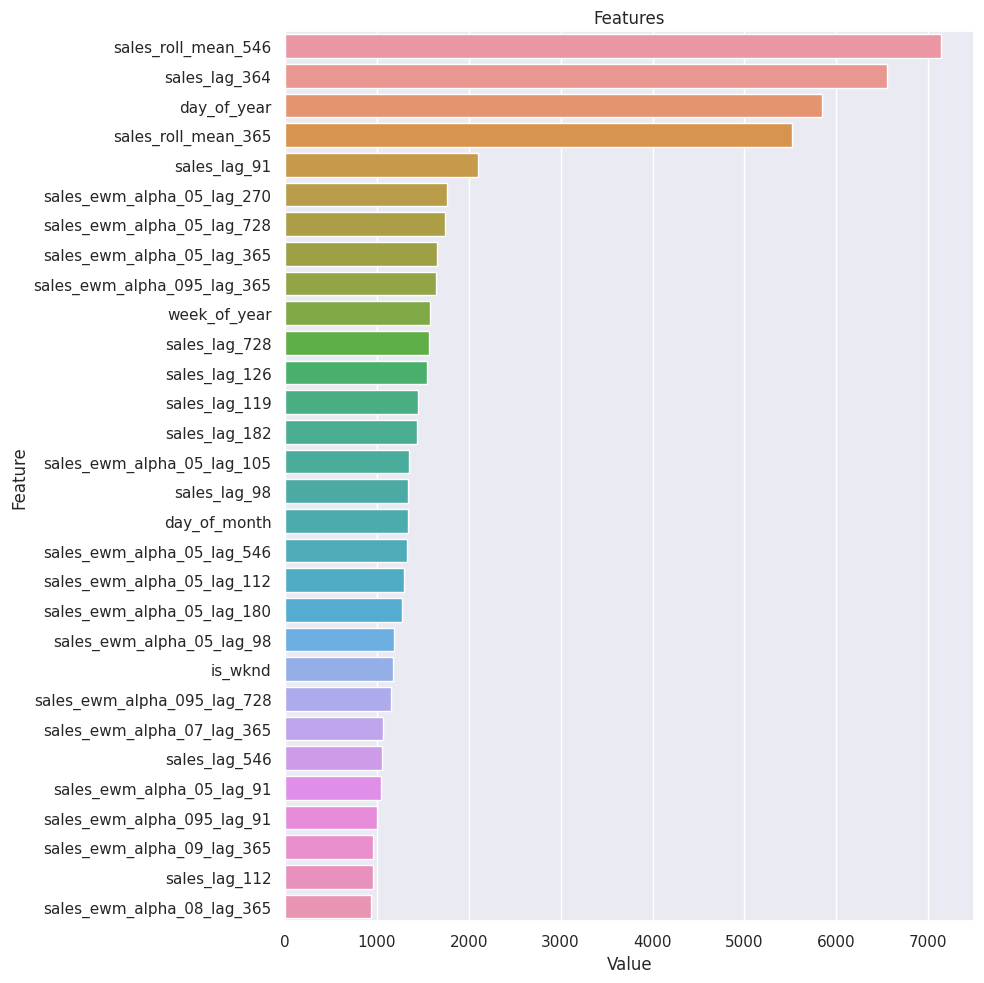

In [35]:
feat_imp = plot_importance(model, X_train, train)

In [36]:
importance_low = feat_imp[feat_imp["Value"] < 50]["Feature"].values

imp_feats = [col for col in cols if col not in importance_low]

In [37]:
importance_low

array(['item_43', 'item_26', 'is_month_start', 'item_14', 'month_9',
       'month_5', 'month_4', 'item_39', 'item_48'], dtype=object)

In [38]:
imp_feats

['day_of_month',
 'day_of_year',
 'week_of_year',
 'is_wknd',
 'is_month_end',
 'sales_lag_91',
 'sales_lag_98',
 'sales_lag_105',
 'sales_lag_112',
 'sales_lag_119',
 'sales_lag_126',
 'sales_lag_182',
 'sales_lag_364',
 'sales_lag_546',
 'sales_lag_728',
 'sales_roll_mean_365',
 'sales_roll_mean_546',
 'sales_ewm_alpha_095_lag_91',
 'sales_ewm_alpha_095_lag_98',
 'sales_ewm_alpha_095_lag_105',
 'sales_ewm_alpha_095_lag_112',
 'sales_ewm_alpha_095_lag_180',
 'sales_ewm_alpha_095_lag_270',
 'sales_ewm_alpha_095_lag_365',
 'sales_ewm_alpha_095_lag_546',
 'sales_ewm_alpha_095_lag_728',
 'sales_ewm_alpha_09_lag_91',
 'sales_ewm_alpha_09_lag_98',
 'sales_ewm_alpha_09_lag_105',
 'sales_ewm_alpha_09_lag_112',
 'sales_ewm_alpha_09_lag_180',
 'sales_ewm_alpha_09_lag_270',
 'sales_ewm_alpha_09_lag_365',
 'sales_ewm_alpha_09_lag_546',
 'sales_ewm_alpha_09_lag_728',
 'sales_ewm_alpha_08_lag_91',
 'sales_ewm_alpha_08_lag_98',
 'sales_ewm_alpha_08_lag_105',
 'sales_ewm_alpha_08_lag_112',
 'sales_ew

## Final Model

In [39]:
train = df.loc[~df.sales.isna()]
y_train = train["sales"]
X_train = train[imp_feats]

test = df.loc[df.sales.isna()]
X_test = test[imp_feats]

In [40]:
final_model = LGBMRegressor(num_leaves=10,
                            learning_rate=0.02,
                            feature_fraction=0.8,
                            max_depth=5,
                            n_estimators=best_iteration,
                            n_jobs=-1,
                            random_state=42,
                            force_col_wise=True)

In [41]:
final_model.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Total Bins 15008
[LightGBM] [Info] Number of data points in the train set: 913000, number of used features: 129
[LightGBM] [Info] Start training from score 3.820443


LGBMRegressor(feature_fraction=0.8, force_col_wise=True, learning_rate=0.02,
              max_depth=5, n_estimators=9996, n_jobs=-1, num_leaves=10,
              random_state=42)

In [42]:
test_preds = final_model.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


In [43]:
test_preds = np.expm1(test_preds)

## Prediction Graphs

In [44]:
df_, train_, test_, sample_sub_ = load()

In [45]:
forecast = pd.DataFrame({"date":test_["date"],
                         "store":test_["store"],
                         "item":test_["item"],
                         "sales":test_preds})

In [46]:
def predicted_graph(store_num, item_num, train, forecast):
    train_data = train[(train.store == store_num) & (train.item == item_num)]
    forecast_data = forecast[(forecast.store == store_num) & (forecast.item == item_num)]
    
    fig = make_subplots(rows=1, cols=1, shared_xaxes=True)
    
    fig.add_trace(go.Scatter(x=train_data.date,
                             y=train_data.sales,
                             name=f"Store {store_num} Item {item_num} Sales",
                             mode='lines'))
    
    fig.add_trace(go.Scatter(x=forecast_data.date,
                             y=forecast_data.sales,
                             name=f"Store {store_num} Item {item_num} Forecast",
                             mode='lines'))
    
    fig.update_layout(title=f"Sales and Forecast for Store {store_num}, Item {item_num}",
                      xaxis_title="Date",
                      yaxis_title="Sales",
                      legend_title="Legend",
                      hovermode="x unified")
    
    fig.update_xaxes(rangeslider_visible=True,
                     rangeselector=dict(buttons=list([dict(count=1, label="1m", step="month", stepmode="backward"),
                                                      dict(count=6, label="6m", step="month", stepmode="backward"),
                                                      dict(count=1, label="YTD", step="year", stepmode="todate"),
                                                      dict(count=1, label="1y", step="year", stepmode="backward"),
                                                      dict(step="all")])))
    
    fig.show()

In [47]:
predicted_graph(store_num=2, item_num=23, train=train_, forecast=forecast)

In [48]:
predicted_graph(store_num=5, item_num=12, train=train_, forecast=forecast)

## Submission File

In [49]:
test.head()

,date,sales,id,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2018-01-01,NaN,0.0,1,1,1,2018,0,1,0,13.093843,12.033395,23.246692,17.063136,10.611245,13.691117,17.542678,15.919710,19.173012,12.032116,24.103969,22.816060,12.472220,14.531325,22.392609,16.695005,22.989955,24.801901,18.774592,18.843644,12.003480,12.987531,15.120201,22.770677,17.380051,22.969272,24.605438,18.596446,19.678303,12.017666,14.136684,16.435296,23.481072,18.719979,22.948070,24.207259,18.366501,21.332981,12.097977,15.418629,17.863610,24.114316,20.015174,23.029458,23.791446,18.268850,22.964410,12.271265,18.192747,20.671654,24.971733,22.381769,23.804594,22.867776,18.234876,25.986567,12.903982,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2018-01-02,NaN,1.0,2,2,1,2018,0,0,0,18.513324,17.537195,21.960950,21.189323,24.776434,20.468691,22.757190,11.508807,32.843357,11.380920,22.721320,21.947256,17.723611,17.826566,21.069630,19.834750,30.599498,24.990095,15.188730,30.392182,12.000174,17.498753,17.712020,21.177068,19.738005,30.196927,24.960544,15.359645,29.867830,12.001767,17.227337,17.687059,21.496214,19.743996,29.389614,24.841452,15.673300,29.066596,12.019595,17.225589,17.959083,21.934295,20.004552,28.608837,24.637434,15.980655,28.589323,12.081380,18.096374,19.335827,22.985866,21.190884,27.402297,23.933888,16.617438,28.493284,12.451991,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2018-01-03,NaN,2.0,3,3,1,2018,0,0,0,14.161075,28.198466,21.322805,14.297900,22.940049,20.839798,22.396828,16.174429,20.389757,15.534105,25.913411,21.491872,15.136181,26.541328,20.053482,13.341738,31.929975,23.099505,10.259436,22.419609,15.800009,15.249875,26.071202,20.117707,13.673801,31.819693,23.196054,10.535964,22.786783,15.600177,15.445467,25.137412,20.29924

In [50]:
submission_df = test.loc[:, ["id", "sales"]]
submission_df["sales"] = test_preds
submission_df

,id,sales
0,0.0,12.299936
1,1.0,13.614953
2,2.0,14.587428
3,3.0,15.203592
4,4.0,17.045006
...,...,...
44995,44995.0,72.433092
44996,44996.0,75.351575
44997,44997.0,79.709978
44998,44998.0,85.145525


In [51]:
submission_df["id"] = submission_df.id.astype(int)

submission_df.to_csv("submission.csv", index=False)